# Group Project - NBA Game Winner Predictions For Home Games


# Evan Winter, Nicholas Perry, Jamison Stutsman, Baylor Van Sickle

In [1]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score,
    roc_auc_score, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import statsmodels.api as sm

In [2]:
# === Load and Inspect Data ===
games = pd.read_csv('NBAgames.csv')
print(games.shape)
print(games.columns)
games.info()
print(games.isna().sum())

(26651, 21)
Index(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away', 'HOME_TEAM_WINS'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26651 entries, 0 to 26650
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     26651 non-null  object 
 1   GAME_ID           26651 non-null  int64  
 2   GAME_STATUS_TEXT  26651 non-null  object 
 3   HOME_TEAM_ID      26651 non-null  int64  
 4   VISITOR_TEAM_ID   26651 non-null  int64  
 5   SEASON            26651 non-null  int64  
 6   TEAM_ID_home      26651 non-null  int64  
 7   PTS_home          26552 non-null  float64
 8   FG_PCT_home       26552 non-null  float

In [3]:
# Drop missing values
gamesc = games.dropna()

# Check for duplicates
print(f"Number of duplicate rows: {gamesc.duplicated().sum()}")

# Filter numerical columns
gamesr = gamesc.select_dtypes(include='number')

Number of duplicate rows: 0


In [4]:
# === Feature Engineering ===
gamesr['EFF_home'] = gamesr['PTS_home'] + gamesr['AST_home'] + gamesr['REB_home']
gamesr['EFF_away'] = gamesr['PTS_away'] + gamesr['AST_away'] + gamesr['REB_away']

# Drop original columns used in EFF calculations
gamesrd = gamesr.drop(['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON',
                        'TEAM_ID_home', 'TEAM_ID_away',
                        'PTS_home', 'AST_home', 'REB_home',
                        'PTS_away', 'AST_away', 'REB_away'], axis=1)

In [5]:
# Define features and target
X = gamesrd.drop('HOME_TEAM_WINS', axis=1)
y = gamesrd['HOME_TEAM_WINS']

In [6]:
# Drop home team wins from gamesrdf
gamesrdf = gamesrd.drop('HOME_TEAM_WINS', axis=1)

In [7]:
# === OLS Model for Diagnostics ===
x_with_const = sm.add_constant(X)
model = sm.OLS(y, x_with_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         HOME_TEAM_WINS   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     4340.
Date:                Wed, 28 May 2025   Prob (F-statistic):               0.00
Time:                        09:28:01   Log-Likelihood:                -7737.9
No. Observations:               26552   AIC:                         1.549e+04
Df Residuals:                   26543   BIC:                         1.557e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.5283      0.032     16.573   

In [8]:
# === Descriptive Statistics ===
print(gamesrdf.describe())

        FG_PCT_home   FT_PCT_home  FG3_PCT_home   FG_PCT_away   FT_PCT_away  \
count  26552.000000  26552.000000  26552.000000  26552.000000  26552.000000   
mean       0.460735      0.760377      0.356023      0.449732      0.758816   
std        0.056676      0.100677      0.111164      0.055551      0.103429   
min        0.250000      0.143000      0.000000      0.244000      0.143000   
25%        0.422000      0.697000      0.286000      0.412000      0.692000   
50%        0.460000      0.765000      0.357000      0.449000      0.765000   
75%        0.500000      0.833000      0.429000      0.487000      0.833000   
max        0.684000      1.000000      1.000000      0.687000      1.000000   

       FG3_PCT_away      EFF_home      EFF_away  
count  26552.000000  26552.000000  26552.000000  
mean       0.349489    169.653623    164.249397  
std        0.109441     19.077893     19.188330  
min        0.000000     62.000000     59.000000  
25%        0.278000    157.000000    1

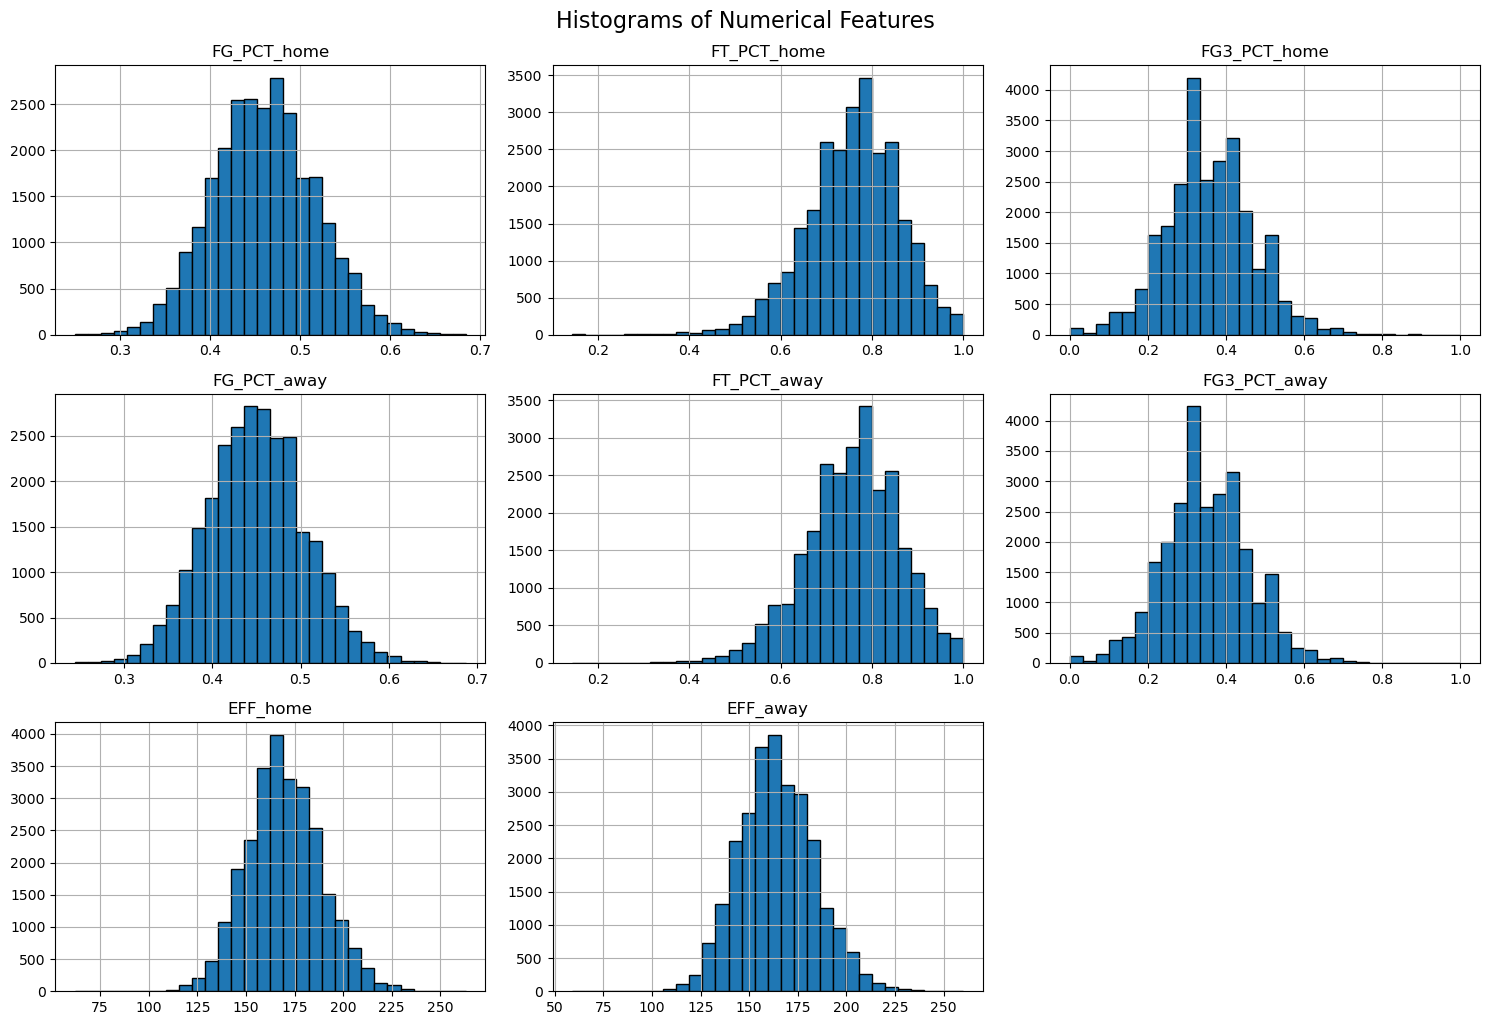

In [9]:
# Histograms
gamesrdf.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.suptitle("Histograms of Numerical Features", fontsize=16, y=1.02)
plt.show()

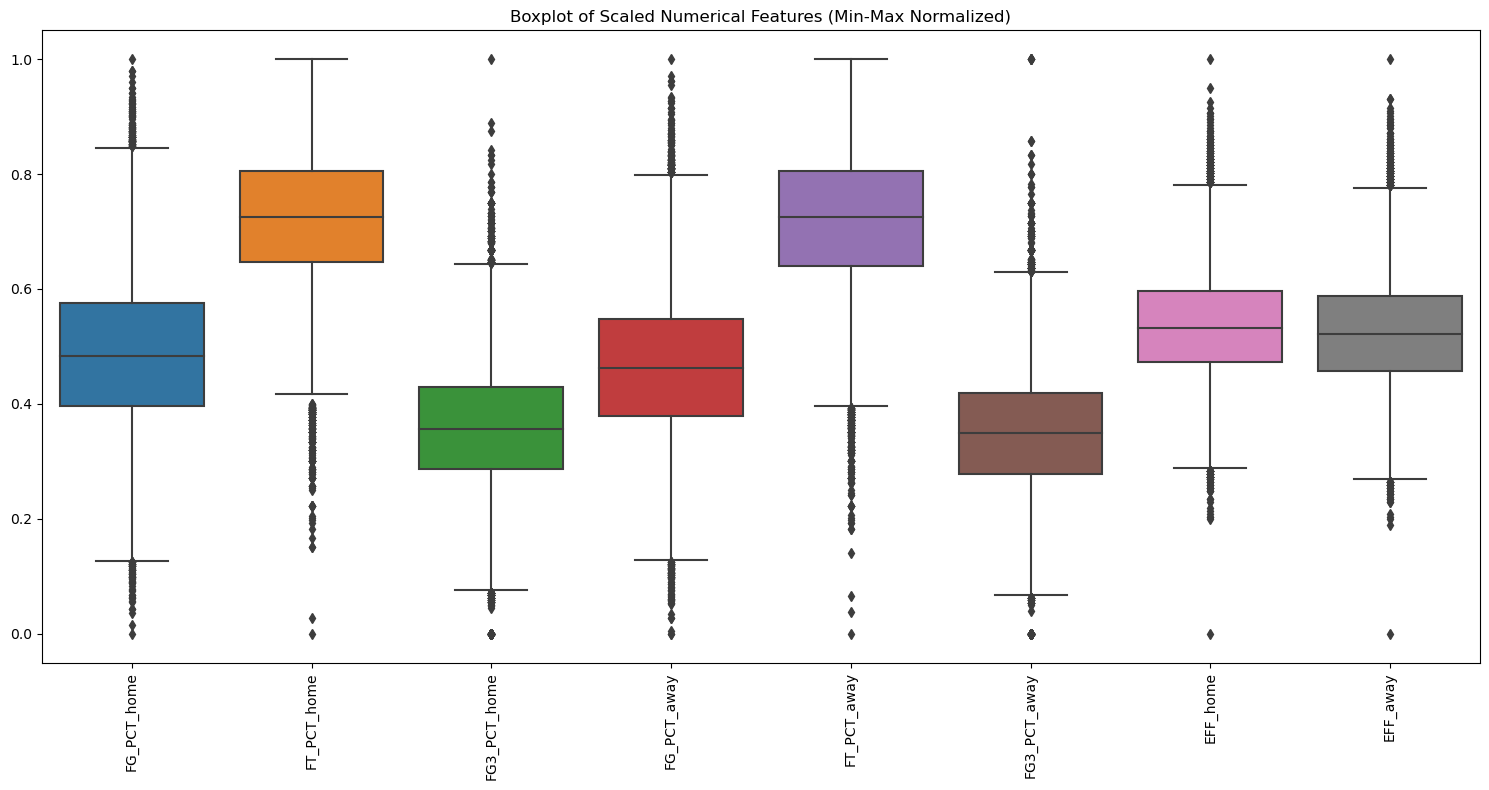

In [10]:
# Boxplots
# Select only numerical columns
numerical_cols = gamesrdf.select_dtypes(include=['float64', 'int64']).columns

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the numerical features
scaled_data = scaler.fit_transform(gamesrdf[numerical_cols])

# Create a DataFrame from the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=numerical_cols)

# Plot the boxplot
plt.figure(figsize=(15, 8))
sns.boxplot(data=scaled_df)
plt.xticks(rotation=90)
plt.title("Boxplot of Scaled Numerical Features (Min-Max Normalized)")
plt.tight_layout()
plt.show()

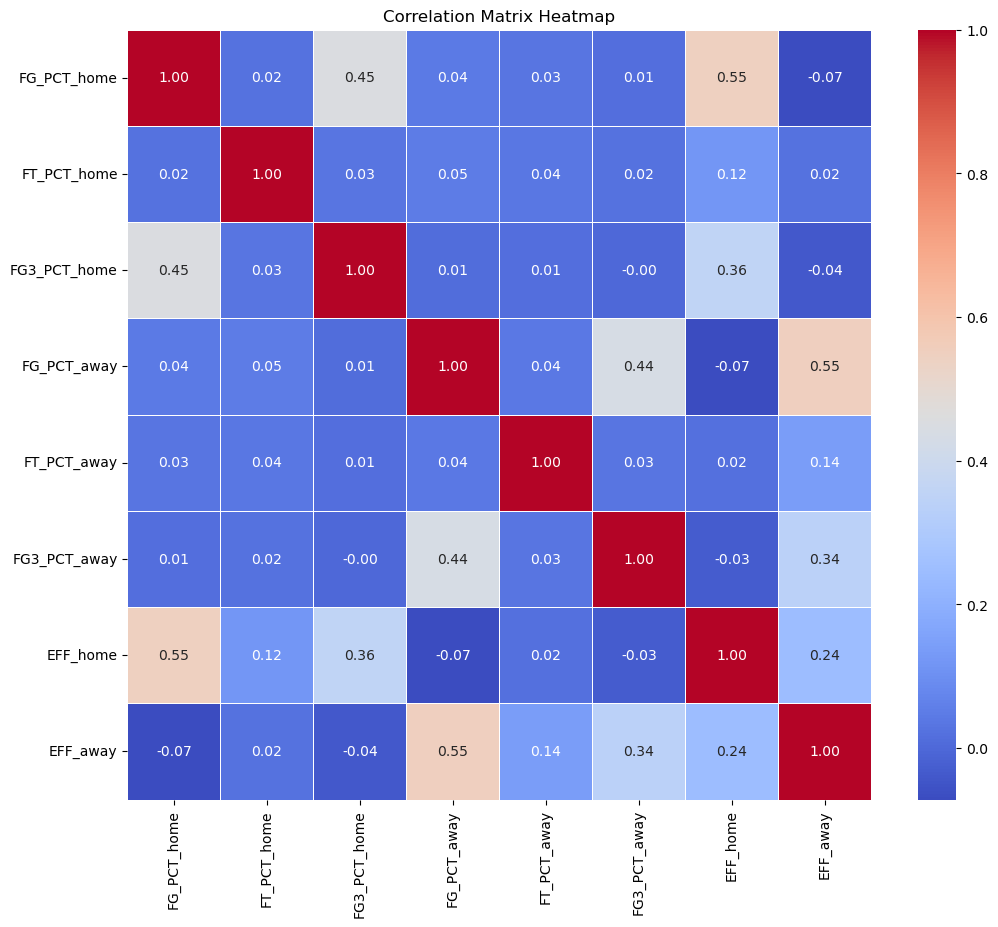

In [11]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(gamesrdf.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

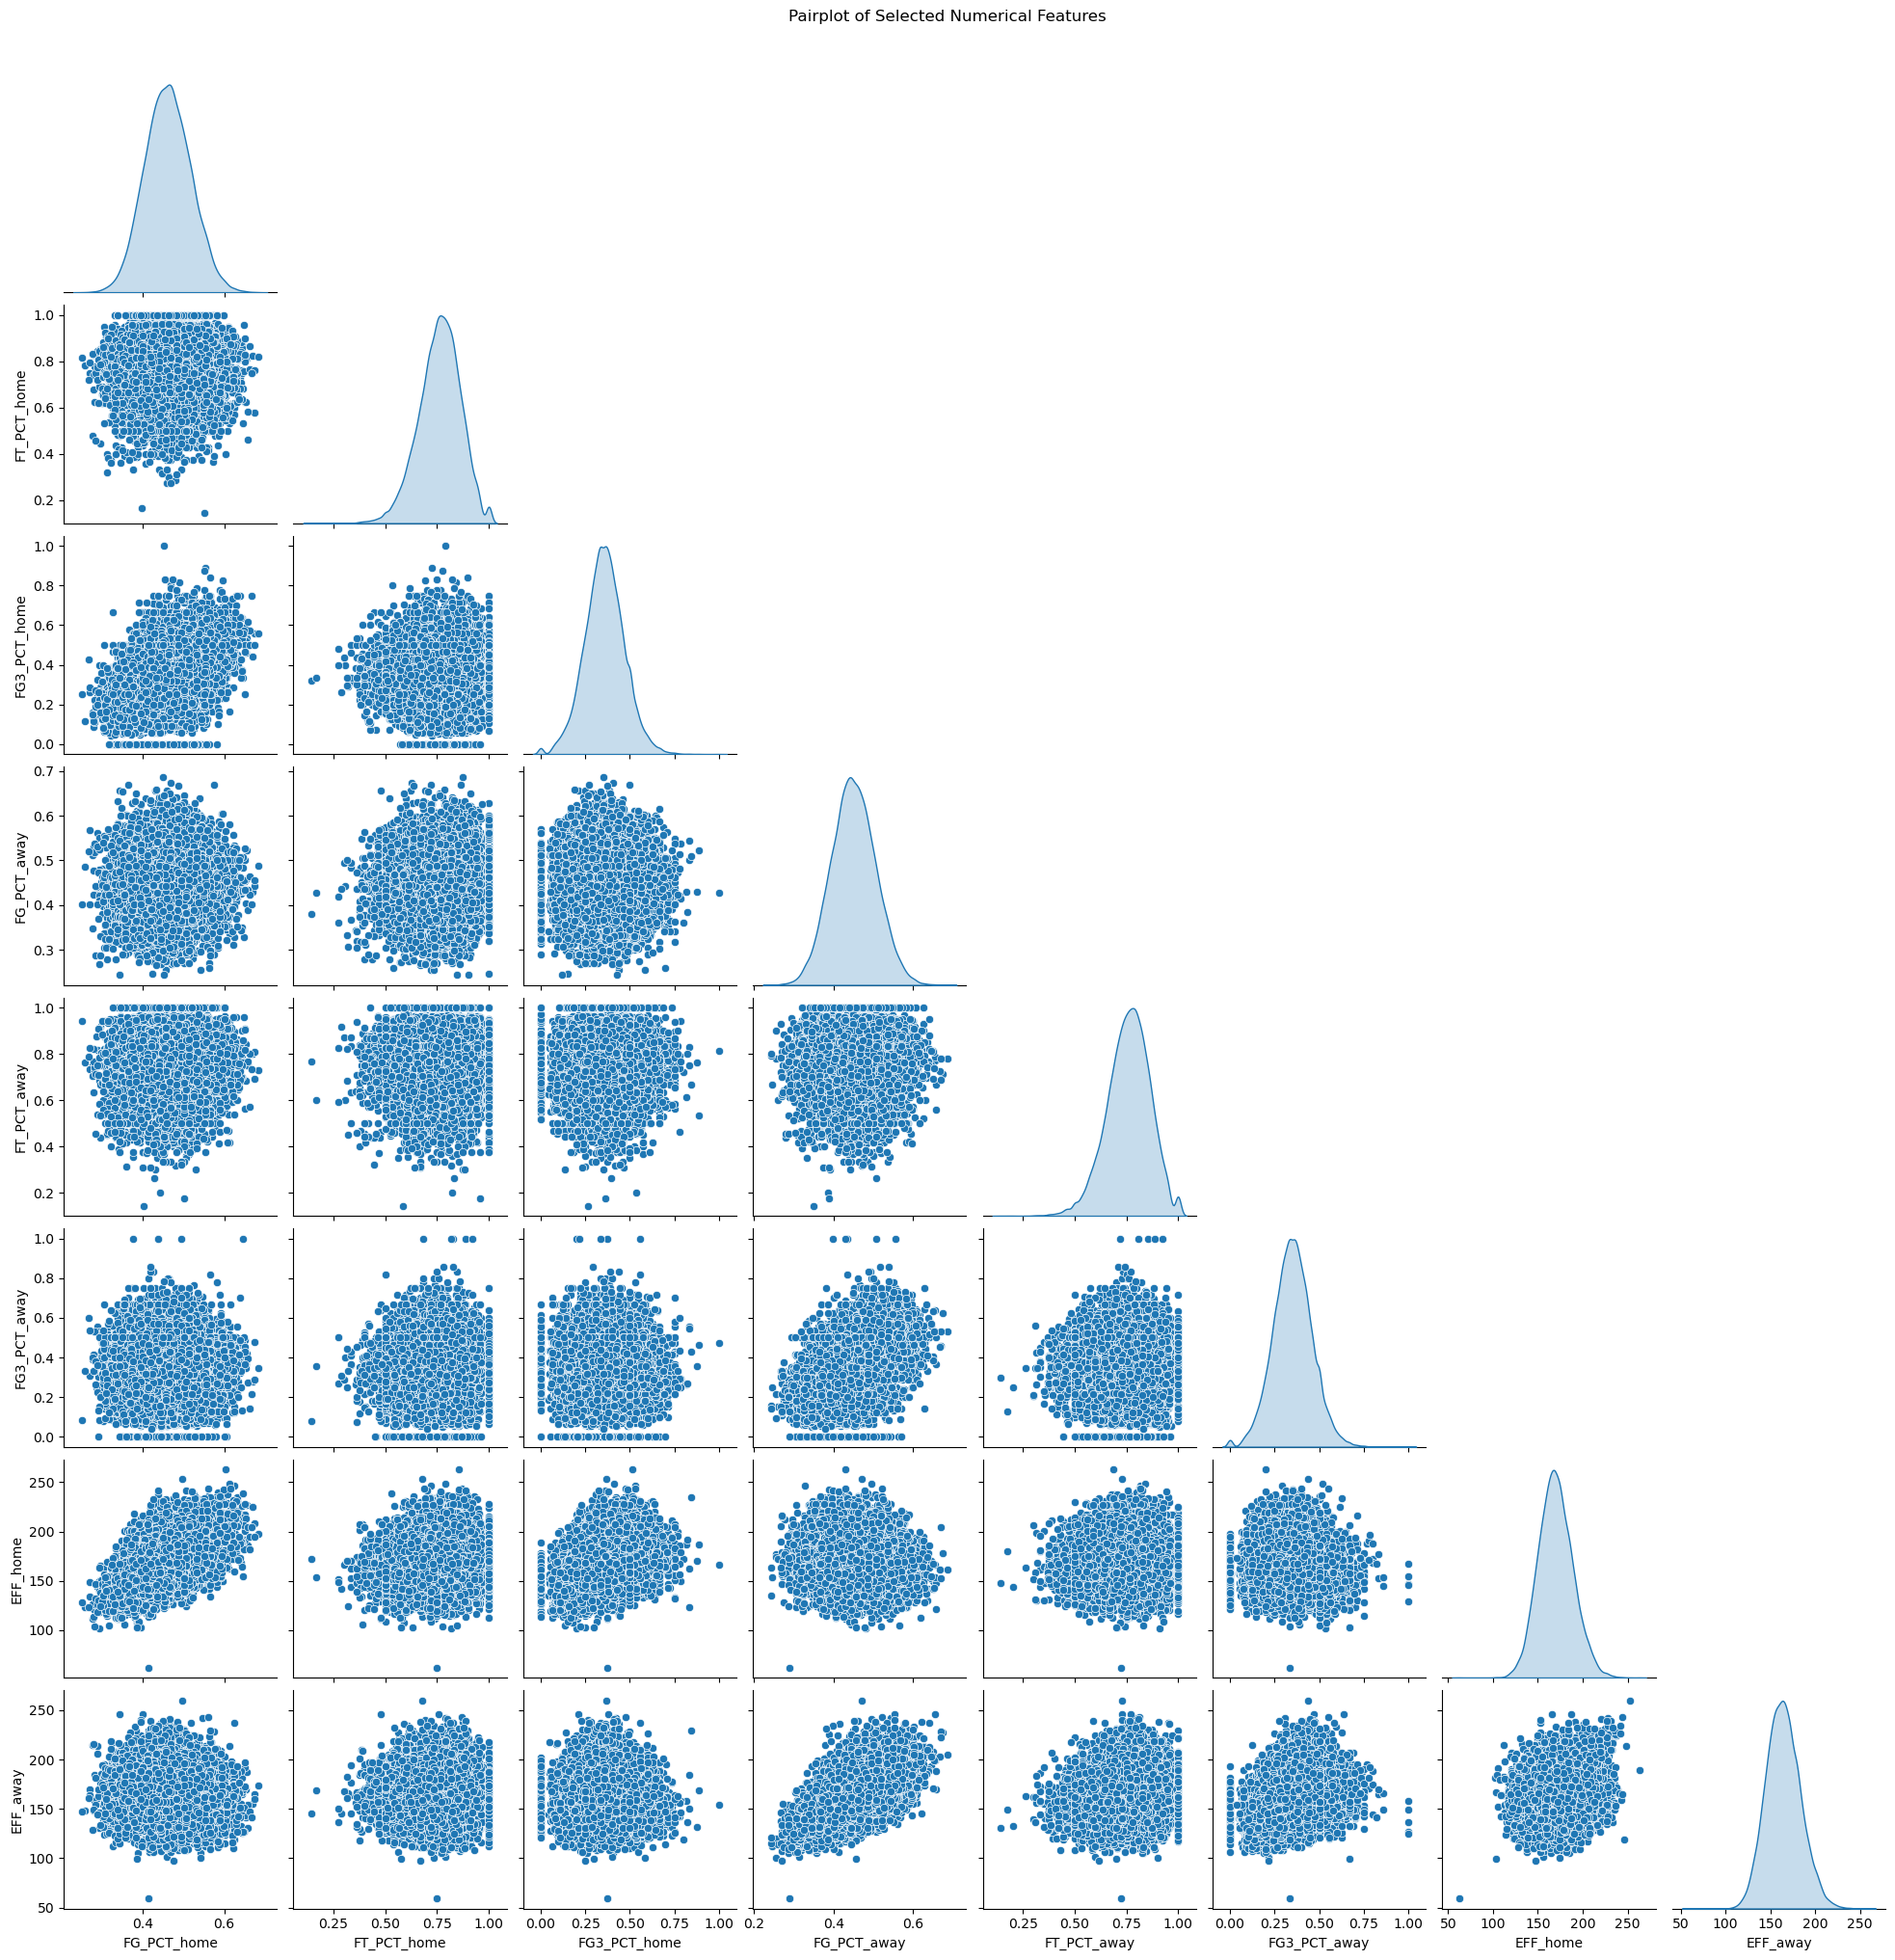

In [12]:
# Pairplot
sns.pairplot(gamesrdf, corner=True, diag_kind='kde')
plt.suptitle("Pairplot of Selected Numerical Features", y=1.02)
plt.show()

In [41]:
# === Model Pipeline ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# Logistic Regression
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print("\nModel Evaluation: Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R² Score:", r2_score(y_test, y_pred))


Model Evaluation: Logistic Regression
Accuracy: 0.9005836942195443
Precision: 0.9319163068747924
Recall: 0.8967721316714605
F1 Score: 0.9140065146579806
RMSE: 0.31530351374581234
R² Score: 0.589276157316069


In [15]:
# Baseline Comparison
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)
print("\nBaseline Model (Dummy Classifier - Majority Class):")
print("Accuracy:", accuracy_score(y_test, y_dummy))
print("Precision:", precision_score(y_test, y_dummy, zero_division=0))
print("Recall:", recall_score(y_test, y_dummy))
print("F1 Score:", f1_score(y_test, y_dummy))


Baseline Model (Dummy Classifier - Majority Class):
Accuracy: 0.5891545848239503
Precision: 0.5891545848239503
Recall: 1.0
F1 Score: 0.7414691943127962


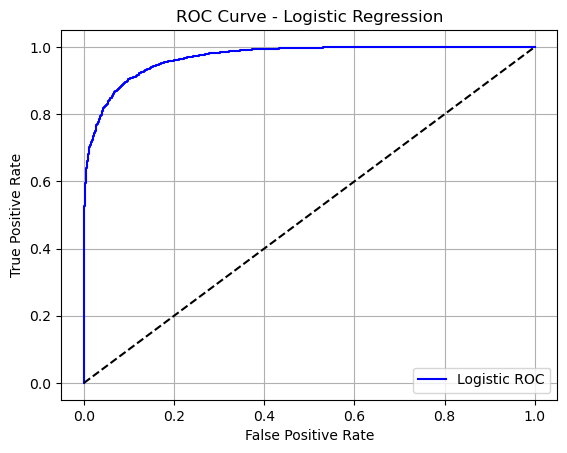

AUC Score (Logistic Regression): 0.9695061631835358


In [16]:
# ROC Curve
y_proba = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='Logistic ROC', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

print("AUC Score (Logistic Regression):", roc_auc_score(y_test, y_proba))

In [43]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

print("\nRandom Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Precision:", precision_score(y_test, rf_pred))
print("Recall:", recall_score(y_test, rf_pred))
print("F1 Score:", f1_score(y_test, rf_pred))
print("RMSE:", mean_squared_error(y_test, rf_pred, squared=False))
print("R² Score:", r2_score(y_test, rf_pred))


Random Forest Model Evaluation:
Accuracy: 0.9002071173037093
Precision: 0.9108441353145748
Recall: 0.9207414509427932
F1 Score: 0.9157660521296885
RMSE: 0.3159001150621676
R² Score: 0.5877203851846904


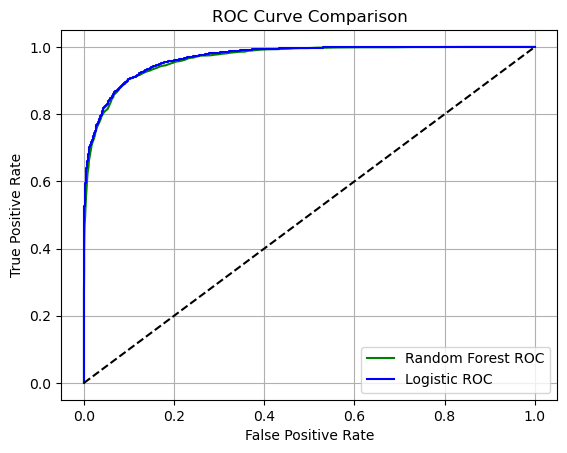

AUC Score (Random Forest): 0.9665883947191042


In [30]:
# ROC Comparison
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
plt.plot(fpr_rf, tpr_rf, label='Random Forest ROC', color='green')
plt.plot(fpr, tpr, label='Logistic ROC', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

print("AUC Score (Random Forest):", roc_auc_score(y_test, rf_proba))

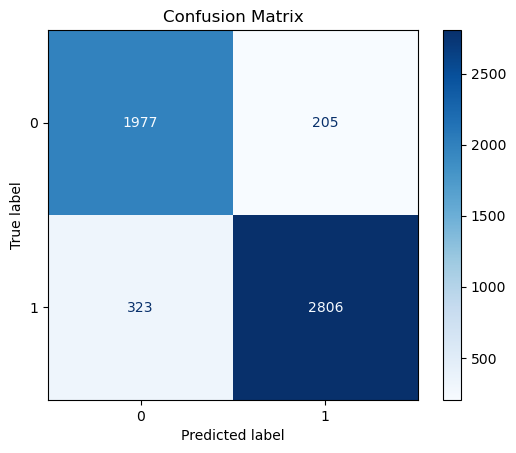

In [32]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

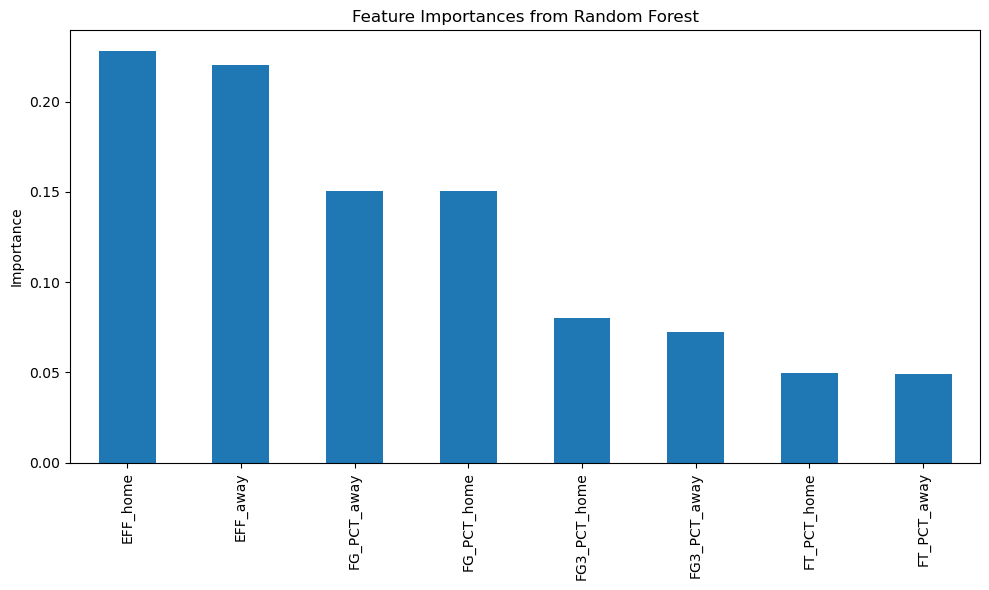

In [33]:
# Feature Importance (Random Forest)
importances = rf.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feat_importance.plot(kind='bar')
plt.title('Feature Importances from Random Forest')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [42]:
# Retrain with Top Features
top_features = feat_importance.head(5).index.tolist()
print("\nTop 5 features used for retraining:", top_features)

X_top = X[top_features]
X_top_scaled = scaler.fit_transform(X_top)

X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_top_scaled, y, test_size=0.3, random_state=42, stratify=y)


Top 5 features used for retraining: ['EFF_home', 'EFF_away', 'FG_PCT_away', 'FG_PCT_home', 'FG3_PCT_home']


In [35]:
logreg_top = LogisticRegression()
logreg_top.fit(X_train_top, y_train_top)
y_pred_top = logreg_top.predict(X_test_top)

print("\nRetrained Model Evaluation (Top Features Only):")
print("Accuracy:", accuracy_score(y_test_top, y_pred_top))
print("Precision:", precision_score(y_test_top, y_pred_top))
print("Recall:", recall_score(y_test_top, y_pred_top))
print("F1 Score:", f1_score(y_test_top, y_pred_top))
print("RMSE:", mean_squared_error(y_test_top, y_pred_top, squared=False))
print("R² Score:", r2_score(y_test_top, y_pred_top))


Retrained Model Evaluation (Top Features Only):
Accuracy: 0.9009540547326136
Precision: 0.9089005235602095
Recall: 0.9245845760545377
F1 Score: 0.9166754673143944
RMSE: 0.3147156578046068
R² Score: 0.5907761612129305


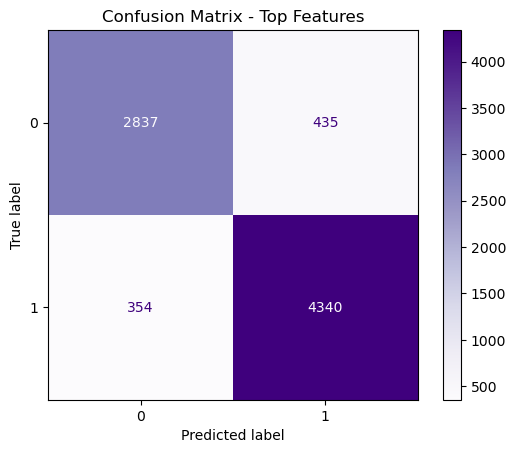

In [36]:
cm_top = confusion_matrix(y_test_top, y_pred_top)
disp_top = ConfusionMatrixDisplay(confusion_matrix=cm_top, display_labels=logreg.classes_)
disp_top.plot(cmap='Purples')
plt.title("Confusion Matrix - Top Features")
plt.show()

In [37]:
# === 6.1 Statistical Summary ===

print("\n--- 6.1 Statistical Summary ---")
print("Final model (top 5 features) evaluation metrics:\n")
print(f"Accuracy:  {accuracy_score(y_test_top, y_pred_top):.4f}")
print(f"Precision: {precision_score(y_test_top, y_pred_top):.4f}")
print(f"Recall:    {recall_score(y_test_top, y_pred_top):.4f}")
print(f"F1 Score:  {f1_score(y_test_top, y_pred_top):.4f}")
print(f"RMSE:      {mean_squared_error(y_test_top, y_pred_top, squared=False):.4f}")
print(f"R² Score:  {r2_score(y_test_top, y_pred_top):.4f}")


--- 6.1 Statistical Summary ---
Final model (top 5 features) evaluation metrics:

Accuracy:  0.9010
Precision: 0.9089
Recall:    0.9246
F1 Score:  0.9167
RMSE:      0.3147
R² Score:  0.5908


In [38]:
# === 6.2 Business Insight ===

print("\n--- 6.2 Business Insight ---")
print("""
This model helps predict the outcome of NBA home games based on pre-game statistics.
The top 5 features identified by the Random Forest (e.g., offensive and defensive ratings,
rebound percentages, etc.) strongly influence whether a home team will win.

Actionable insight: Coaches, analysts, or bettors can use these predictors to:
- Strategize lineups based on key predictive stats.
- Evaluate expected win probability before games.
- Optimize home-court preparation strategies based on the most influential metrics.
""")


--- 6.2 Business Insight ---

This model helps predict the outcome of NBA home games based on pre-game statistics.
The top 5 features identified by the Random Forest (e.g., offensive and defensive ratings,
rebound percentages, etc.) strongly influence whether a home team will win.

Actionable insight: Coaches, analysts, or bettors can use these predictors to:
- Strategize lineups based on key predictive stats.
- Evaluate expected win probability before games.
- Optimize home-court preparation strategies based on the most influential metrics.



In [39]:
# === 6.3 Limitations ===

print("\n--- 6.3 Limitations ---")
print("""
- The dataset only includes numerical data, omitting potential impact factors such as player injuries,
  coaching decisions, or real-time events.
- The outcome is binary (win/loss) without accounting for point spread or margin.
- The model assumes all seasons are comparable; it does not correct for rule changes or roster shifts over time.
- Some correlations might be due to multicollinearity, which could affect model stability.
""")


--- 6.3 Limitations ---

- The dataset only includes numerical data, omitting potential impact factors such as player injuries,
  coaching decisions, or real-time events.
- The outcome is binary (win/loss) without accounting for point spread or margin.
- The model assumes all seasons are comparable; it does not correct for rule changes or roster shifts over time.
- Some correlations might be due to multicollinearity, which could affect model stability.



In [40]:
# === 6.4 Future Work ===

print("\n--- 6.4 Future Work ---")
print("""
- Add categorical features such as day of the week, team rest days, or back-to-back games.
- Explore ensemble models (e.g., XGBoost) or neural networks for improved accuracy.
- Incorporate advanced player-level stats to refine predictions.
- Extend the model to away games or betting spreads for broader use cases.
- Implement SHAP values or LIME for deeper feature interpretability.
""")


--- 6.4 Future Work ---

- Add categorical features such as day of the week, team rest days, or back-to-back games.
- Explore ensemble models (e.g., XGBoost) or neural networks for improved accuracy.
- Incorporate advanced player-level stats to refine predictions.
- Extend the model to away games or betting spreads for broader use cases.
- Implement SHAP values or LIME for deeper feature interpretability.

